<a href="https://colab.research.google.com/github/Praxis-QR/DeepLearning/blob/main/AI_DL_Chapter_7B_Reinforcement_Learning_LunarLander_v2_DQN_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://1.bp.blogspot.com/-WAjYIaQofo0/YEB0cQsSGSI/AAAAAAAAkoE/TpQcWBRGtu0N010lmiTS9cFHuGwXB45PQCLcBGAsYHQ/s16000/colabHeader00.png)<br>

<hr>

[Prithwis Mukerjee](http://www.yantrajaal.com) / [Praxis Business School](http://praxis.ac.in/) / [Book Website](http://aidl4managers.blogspot.com) 

https://towardsdatascience.com/ai-learning-to-land-a-rocket-reinforcement-learning-84d61f97d055 <br>
https://github.com/fakemonk1/Reinforcement-Learning-Lunar_Lander

#Lunar Lander

#Install, imports

In [1]:
# install required system dependencies
!apt-get install -y xvfb x11-utils > /dev/null
#!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.*  PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.* > /dev/null
!pip install gym[box2d] pyvirtualdisplay  PyOpenGL PyOpenGL-accelerate > /dev/null

In [3]:
import gym
import numpy as np
import pandas as pd
from collections import deque
import random

from keras import Sequential
from keras.layers import Dense
from keras.activations import relu, linear
#from keras.optimizers import Adam -- https://stackoverflow.com/questions/62707558/importerror-cannot-import-name-adam-from-keras-optimizers
from tensorflow.keras.optimizers import Adam
from keras.losses import mean_squared_error
from keras.models import load_model

import pickle
from matplotlib import pyplot as plt

from IPython import display
from IPython.display import Image

from IPython.display import clear_output

In [4]:
import pyvirtualdisplay
_display = pyvirtualdisplay.Display(visible=False,size=(1400, 900))  # use False with Xvfb                 
_ = _display.start()
!echo $DISPLAY

:0


#The DQN Class - Deep Q Network

In [5]:
class DQN:
    def __init__(self, env, lr, gamma, epsilon, epsilon_decay):

        self.env = env
        self.action_space = env.action_space
        self.observation_space = env.observation_space
        self.counter = 0

        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.rewards_list = []

        self.replay_memory_buffer = deque(maxlen=500000)
        self.batch_size = 64
        self.epsilon_min = 0.01
        self.num_action_space = self.action_space.n
        self.num_observation_space = env.observation_space.shape[0]
        self.model = self.initialize_model()

    def initialize_model(self):
        model = Sequential()
        model.add(Dense(512, input_dim=self.num_observation_space, activation=relu))
        model.add(Dense(256, activation=relu))
        model.add(Dense(self.num_action_space, activation=linear))

        # Compile the model
        model.compile(loss=mean_squared_error,optimizer=Adam(lr=self.lr))
        print(model.summary())
        return model

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return random.randrange(self.num_action_space)

        predicted_actions = self.model.predict(state)
        return np.argmax(predicted_actions[0])

    def add_to_replay_memory(self, state, action, reward, next_state, done):
        self.replay_memory_buffer.append((state, action, reward, next_state, done))

    def learn_and_update_weights_by_reply(self):

        # replay_memory_buffer size check
        if len(self.replay_memory_buffer) < self.batch_size or self.counter != 0:
            return

        # Early Stopping
        if np.mean(self.rewards_list[-10:]) > 180:
            return

        random_sample = self.get_random_sample_from_replay_mem()
        states, actions, rewards, next_states, done_list = self.get_attribues_from_sample(random_sample)
        targets = rewards + self.gamma * (np.amax(self.model.predict_on_batch(next_states), axis=1)) * (1 - done_list)
        target_vec = self.model.predict_on_batch(states)
        indexes = np.array([i for i in range(self.batch_size)])
        target_vec[[indexes], [actions]] = targets

        self.model.fit(states, target_vec, epochs=1, verbose=0)

    def get_attribues_from_sample(self, random_sample):
        states = np.array([i[0] for i in random_sample])
        actions = np.array([i[1] for i in random_sample])
        rewards = np.array([i[2] for i in random_sample])
        next_states = np.array([i[3] for i in random_sample])
        done_list = np.array([i[4] for i in random_sample])
        states = np.squeeze(states)
        next_states = np.squeeze(next_states)
        return np.squeeze(states), actions, rewards, next_states, done_list

    def get_random_sample_from_replay_mem(self):
        random_sample = random.sample(self.replay_memory_buffer, self.batch_size)
        return random_sample

    def train(self, num_episodes=2000, can_stop=True):
        for episode in range(num_episodes):
            state = env.reset()
            reward_for_episode = 0
            num_steps = 1000
            state = np.reshape(state, [1, self.num_observation_space])
            for step in range(num_steps):
                env.render()
                received_action = self.get_action(state)
                # print("received_action:", received_action)
                next_state, reward, done, info = env.step(received_action)
                next_state = np.reshape(next_state, [1, self.num_observation_space])
                # Store the experience in replay memory
                self.add_to_replay_memory(state, received_action, reward, next_state, done)
                # add up rewards
                reward_for_episode += reward
                state = next_state
                self.update_counter()
                self.learn_and_update_weights_by_reply()

                if done:
                    break
            self.rewards_list.append(reward_for_episode)

            # Decay the epsilon after each experience completion
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

            # Check for breaking condition
            last_rewards_mean = np.mean(self.rewards_list[-100:])
            if last_rewards_mean > 200 and can_stop:
                print("DQN Training Complete...")
                break
            if (episode%100 == 0):
                print(episode, "\t: Episode || Reward: ",reward_for_episode, "\t|| Average Reward: ",last_rewards_mean, "\t epsilon: ", self.epsilon )

            

    def update_counter(self):
        self.counter += 1
        step_size = 5
        self.counter = self.counter % step_size

    def save(self, name):
        self.model.save(name)

In [6]:
def test_already_trained_model(trained_model):
    rewards_list = []
    #num_test_episode = 100
    num_test_episode = 10
    env = gym.make("LunarLander-v2")
    print("Starting Testing of the trained model...")

    step_count = 1000

    for test_episode in range(num_test_episode):
        current_state = env.reset()
        num_observation_space = env.observation_space.shape[0]
        current_state = np.reshape(current_state, [1, num_observation_space])
        reward_for_episode = 0
        for step in range(step_count):
            env.render()
            selected_action = np.argmax(trained_model.predict(current_state)[0])
            new_state, reward, done, info = env.step(selected_action)
            new_state = np.reshape(new_state, [1, num_observation_space])
            current_state = new_state
            reward_for_episode += reward
            if done:
                break
        rewards_list.append(reward_for_episode)
        print(test_episode, "\t: Episode || Reward: ", reward_for_episode)

    return rewards_list


#Setting the environment <br>
http://gym.openai.com/envs/LunarLander-v2/

In [7]:
env = gym.make('LunarLander-v2')
print("Action Space",env.action_space)
print("State Space",env.observation_space)

Action Space Discrete(4)
State Space Box(-inf, inf, (8,), float32)


In [8]:
# set seeds
env.seed(39)
np.random.seed(39)

# setting up params
lr = 0.001
epsilon = 1.0
epsilon_decay = 0.995
gamma = 0.99
#training_episodes = 2000
training_episodes = 2000


In [ ]:
# This cell will take nearly 2 hours to execute
#CPU times: user 2h 29min 18s, sys: 5min 30s, total: 2h 34min 48s
#Wall time: 2h 27min 21s
# Better to use a stored model
#%%time
#print('St')
#model = DQN(env, lr, gamma, epsilon, epsilon_decay)
#model.train(training_episodes, True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               4608      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 136,964
Trainable params: 136,964
Non-trainable params: 0
_________________________________________________________________
None


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 	: Episode || Reward:  3.6280622855718008 	|| Average Reward:  3.6280622855718008 	 epsilon:  0.995
100 	: Episode || Reward:  -39.55360675121894 	|| Average Reward:  -123.74399511158474 	 epsilon:  0.6027415843082742
200 	: Episode || Reward:  -92.48823487384794 	|| Average Reward:  -89.79533184574879 	 epsilon:  0.36512303261753626
300 	: Episode || Reward:  -51.13127781898399 	|| Average Reward:  -32.810442435153576 	 epsilon:  0.2211807388415433
400 	: Episode || Reward:  -179.02353479438995 	|| Average Reward:  107.47023401404327 	 epsilon:  0.13398475271138335
500 	: Episode || Reward:  266.8650391967432 	|| Average Reward:  146.1665704765544 	 epsilon:  0.0811640021330769
DQN Training Complete...
CPU times: user 2h 29min 18s, sys: 5min 30s, total: 2h 34min 48s
Wall time: 2h 27min 21s


In [ ]:
# Save models to Google Drive
#!ls drive/MyDrive/Praxis/'Non Syllabus'/'AI_DL for Business Managers'/Data
#!cp AIDL_LL*.* drive/MyDrive/Praxis/'Non Syllabus'/'AI_DL for Business Managers'/Data
#!cp drive/MyDrive/Praxis/'Non Syllabus'/'AI_DL for Business Managers'/Data/AIDL_LL*.* .

In [10]:

# Save or load trained model
#model.save("AIDL_LLv2_model_01022021.h5")
#https://drive.google.com/file/d/1JVhjK3zFpPzcR-uYSjZAhawqUEjP8_ZP/view?usp=sharing
#!gdown https://drive.google.com/uc?id=1JVhjK3zFpPzcR-uYSjZAhawqUEjP8_ZP
!wget -O AIDL_LLv2_model_01022021.h5 https://github.com/Praxis-QR/DeepLearning/blob/main/models/AIDL_LLv2_model_01022021.h5?raw=true

# Save or load Rewards list
#pickle.dump(model.rewards_list, open("AIDL_LLv2_rewards_01022021.p", "wb"))
#https://drive.google.com/file/d/1--dQo93f8P4quWAxreehLHg3YbgVJDTJ/view?usp=sharing
#rewards_list = pickle.load(open("LLv2train_rewards_list.p", "rb"))
!gdown https://drive.google.com/uc?id=1--dQo93f8P4quWAxreehLHg3YbgVJDTJ
!wget -O AIDL_LLv2_rewards_01022021.p https://github.com/Praxis-QR/DeepLearning/blob/main/models/AIDL_LLv2_rewards_01022021.p?raw=true

--2021-10-25 07:31:20--  https://github.com/Praxis-QR/DeepLearning/blob/main/models/AIDL_LLv2_model_01022021.h5?raw=true
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Praxis-QR/DeepLearning/raw/main/models/AIDL_LLv2_model_01022021.h5 [following]
--2021-10-25 07:31:21--  https://github.com/Praxis-QR/DeepLearning/raw/main/models/AIDL_LLv2_model_01022021.h5
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Praxis-QR/DeepLearning/main/models/AIDL_LLv2_model_01022021.h5 [following]
--2021-10-25 07:31:21--  https://raw.githubusercontent.com/Praxis-QR/DeepLearning/main/models/AIDL_LLv2_model_01022021.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubuserco

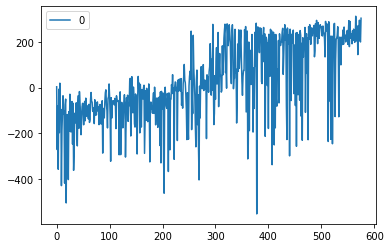

In [11]:
# plot reward in graph
rewards_list = pickle.load(open("AIDL_LLv2_rewards_01022021.p", "rb"))
reward_df = pd.DataFrame(rewards_list)
reward_df.plot()
#plot_df(reward_df, "Figure 1: Reward for each training episode", "Reward for each training episode", "Episode","Reward")

In [12]:
# Test the model
trained_model = load_model("AIDL_LLv2_model_01022021.h5")
test_rewards = test_already_trained_model(trained_model)

Starting Testing of the trained model...
0 	: Episode || Reward:  229.03985046146707
1 	: Episode || Reward:  153.87296314657135
2 	: Episode || Reward:  109.876427590736
3 	: Episode || Reward:  218.37783228837506
4 	: Episode || Reward:  259.4966765173183
5 	: Episode || Reward:  180.62934722960097
6 	: Episode || Reward:  212.0590345918099
7 	: Episode || Reward:  115.55942491382794
8 	: Episode || Reward:  214.93554116879534
9 	: Episode || Reward:  195.3864789309883


In [ ]:
#pickle.dump(test_rewards, open("LLv2test_rewards.p", "wb"))
#test_rewards = pickle.load(open("LLv2test_rewards.p", "rb"))
#test_rewards

Training and Testing Completed...!


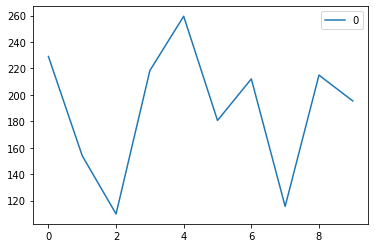

In [13]:
test_rewards_df=pd.DataFrame(test_rewards)
test_rewards_df.plot()
#plot_df2(pd.DataFrame(test_rewards), "Figure 2: Reward for each testing episode","Reward for each testing episode", "Episode", "Reward")
print("Training and Testing Completed...!")

In [14]:
#this takes an RGB render of the environment and 
#creates a matplotlib image that is shown in the virtual display
#fig, ax = plt.subplots(figsize=(15, 5))
#ax.axis('off')
#env.reset()
def ShowState(z,m,):
    #img = ax.imshow(z)
    plt.text(10, 24, str(m), bbox=dict(fill=True))
    ax.imshow(z)
    #img.set_data(env.render(mode='rgb_array')) 
    display.display(plt.gcf())
    display.clear_output(wait=True)

#ShowState(env.render(mode='rgb_array'),0)

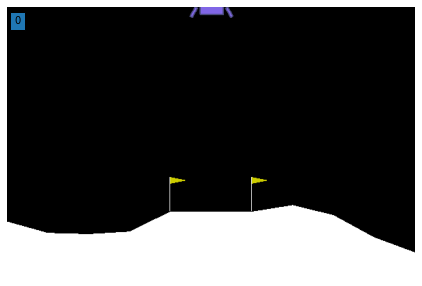

In [15]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.axis('off')
env.reset()
ShowState(env.render(mode='rgb_array'),0)

#One Trip

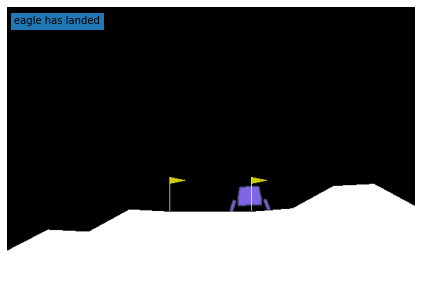

In [16]:
# Set the following parameters
trained = True     # toggle to False to see random actions
graphic = True     # toggle to False to see text output
modelName = "AIDL_LLv2_model_01022021.h5"
speed = 5    # for animation
#-----------------------------------------------
fig, ax = plt.subplots(figsize=(15, 5))
ax.axis('off')
if trained:
    trained_model = load_model(modelName)
step_count = 1000
current_state = env.reset()
num_observation_space = env.observation_space.shape[0]
current_state = np.reshape(current_state, [1, num_observation_space])
reward_for_episode = 0
for step in range(step_count):
    #env.render()
    if graphic and (step%speed == 0):
        ShowState(env.render(mode='rgb_array'),step)
    if trained:
        selected_action = np.argmax(trained_model.predict(current_state)[0])
    else:
        selected_action = env.action_space.sample()
    #print("C:",current_state, selected_action)
    new_state, reward, done, info = env.step(selected_action)
    new_state = np.reshape(new_state, [1, num_observation_space])
    current_state = new_state
    reward_for_episode += reward
    if (not graphic) and (step%10 == 0):
        print("step : ",step," reward : ", reward)
    if done:
        break
#rewards_list.append(reward_for_episode)
print("\t: Episode || Reward: ", reward_for_episode)
if (reward_for_episode > 200):
    if graphic:
        ShowState(env.render(mode='rgb_array'),'eagle has landed')
    else:
        print('eagle has landed')

#Chronobooks <br>
![alt text](https://1.bp.blogspot.com/-lTiYBkU2qbU/X1er__fvnkI/AAAAAAAAjtE/GhDR3OEGJr4NG43fZPodrQD5kbxtnKebgCLcBGAsYHQ/s600/Footer2020-600x200.png)<hr>
Chronotantra and Chronoyantra are two science fiction novels that explore the collapse of human civilisation on Earth and then its rebirth and reincarnation both on Earth as well as on the distant worlds of Mars, Titan and Enceladus. But is it the human civilisation that is being reborn? Or is it some other sentience that is revealing itself. 
If you have an interest in AI and found this material useful, you may consider buying these novels, in paperback or kindle, from [http://bit.ly/chronobooks](http://bit.ly/chronobooks)

![CC-BY-SA](https://licensebuttons.net/l/by-sa/3.0/88x31.png) The contents of this website are released under creative commons 

#Testing Stuff Below

KeyboardInterrupt: ignored

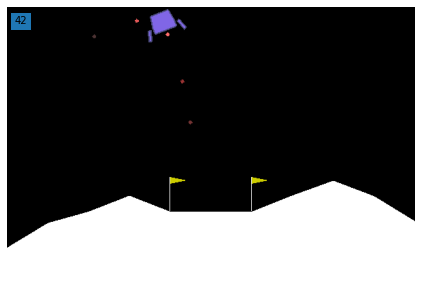

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.axis('off')
#trained_model = load_model("LLv2trained_model31012021.h5")
step_count = 1000
current_state = env.reset()
num_observation_space = env.observation_space.shape[0]
current_state = np.reshape(current_state, [1, num_observation_space])
reward_for_episode = 0
for step in range(step_count):
    #env.render()
    ShowState(env.render(mode='rgb_array'),step)
    #selected_action = np.argmax(trained_model.predict(current_state)[0])
    selected_action = env.action_space.sample()
    #print("C:",current_state, selected_action)
    new_state, reward, done, info = env.step(selected_action)
    new_state = np.reshape(new_state, [1, num_observation_space])
    #print("N:",new_state, reward)
    current_state = new_state
    reward_for_episode += reward
    if done:
        break
rewards_list.append(reward_for_episode)
print("\t: Episode || Reward: ", reward_for_episode)

C: [[ 0.08923988  0.6837894   0.18326014 -0.54505455  0.11465751  0.13286045
   0.          0.        ]] 2


KeyboardInterrupt: ignored

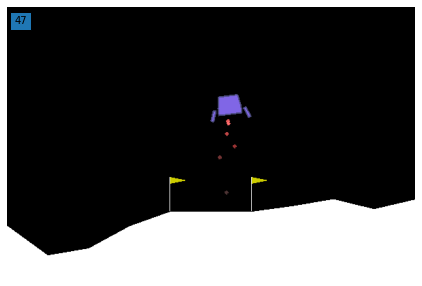

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.axis('off')
trained_model = load_model("LLv2trained_model31012021.h5")
step_count = 1000
current_state = env.reset()
num_observation_space = env.observation_space.shape[0]
current_state = np.reshape(current_state, [1, num_observation_space])
reward_for_episode = 0
for step in range(step_count):
    #env.render()
    ShowState(env.render(mode='rgb_array'),step)
    selected_action = np.argmax(trained_model.predict(current_state)[0])
    #selected_action = env.action_space.sample()
    print("C:",current_state, selected_action)
    new_state, reward, done, info = env.step(selected_action)
    new_state = np.reshape(new_state, [1, num_observation_space])
    #print("N:",new_state, reward)
    current_state = new_state
    reward_for_episode += reward
    if done:
        break
#rewards_list.append(reward_for_episode)
#print("\t: Episode || Reward: ", reward_for_episode)
